<a href="https://colab.research.google.com/github/linhlinhle997/low-resource-nmt-bart-t5/blob/develop/nmt_bart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers sentencepiece datasets accelerate evaluate sacrebleu

In [ ]:
import os
from tqdm import tqdm
from datasets import load_dataset
import numpy as np
import evaluate
import matplotlib.pyplot as plt

import torch
from transformers import (
    AutoTokenizer,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    pipeline,
    DefaultFlowCallback
)
import sacrebleu
import warnings

warnings.filterwarnings("ignore")

In [ ]:
ds = load_dataset("thainq107/iwslt2015-en-vi")

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/133317 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1268 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 133317
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
})

In [ ]:
single_sample = ds["train"][0]
single_sample

{'en': 'Rachel Pike : The science behind a climate headline',
 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}

## Tokenizer

In [ ]:
model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [ ]:
print(tokenizer(single_sample["en"]))
print(tokenizer(single_sample["vi"]))

{'input_ids': [250004, 127055, 66937, 13, 152, 581, 41664, 50155, 10, 153552, 10336, 2256, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [250004, 67766, 2546, 218877, 858, 889, 10037, 6248, 1893, 17964, 42254, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Encoding

In [ ]:
MAX_LEN = 150

def preprocess_fnc(examples):
    input_ids = tokenizer(
        examples["en"], padding="max_length", truncation=True, max_length=MAX_LEN
    )["input_ids"]

    labels = tokenizer(
        examples["vi"], padding="max_length", truncation=True, max_length=MAX_LEN
    )["input_ids"]

    labels = [
        [-100 if item == tokenizer.pad_token_id else item for item in label]
        for label in labels
    ]

    return {"input_ids": input_ids, "labels": labels}


preprocessed_ds = ds.map(preprocess_fnc, batched=True)

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [ ]:
pre_single_sample = preprocess_fnc({
    "en": [single_sample["en"]],
    "vi": [single_sample["vi"]]
})
print(pre_single_sample)

{'input_ids': [[250004, 127055, 66937, 13, 152, 581, 41664, 50155, 10, 153552, 10336, 2256, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[250004, 67766, 2546, 218877, 858, 889, 10037, 6248, 1893, 17964, 42254, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

## Model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, ignore_mismatched_sizes=True)

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

## Evaluation

In [ ]:
metric = evaluate.load("sacrebleu")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds] # Remove extra spaces from predictions
    labels = [[label.strip()] for label in labels] # Ensure labels are nested lists
    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 with the tokenizer's padding token ID
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode tokenized predictions and labels into human-readable text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {"bleu": result["score"]}

## Trainer

In [ ]:
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
output_dir = "./en-vi-mbart50"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    logging_strategy="steps",
    logging_steps=100,
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=1,
    num_train_epochs=1,
    load_best_model_at_end=True,
    fp16=True,
    dataloader_num_workers=4,
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu
5000,1.162900,1.276263,34.335475


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=8333, training_loss=1.184129833302463, metrics={'train_runtime': 19731.2371, 'train_samples_per_second': 6.757, 'train_steps_per_second': 0.422, 'total_flos': 4.23215682527232e+16, 'train_loss': 1.184129833302463, 'epoch': 1.0})

 Save model

In [ ]:
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Model saved to ./en-vi-mbart50


Plot training loss

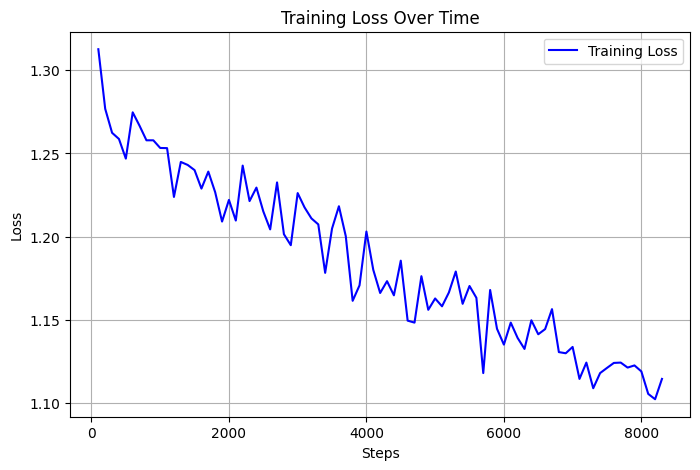

In [ ]:
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()

## Inference

Load model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(output_dir)

In [ ]:
translator = pipeline("translation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


Test with greedy search

In [ ]:
translated_text = translator("I go to school", src_lang="en_XX", tgt_lang="vi_VN", num_beams=1)
translated_text

[{'translation_text': 'Tôi đi học'}]

In [ ]:
pred_sentences = []
for text in ds["test"]["en"]:
    output = translator(
        text,
        max_length=MAX_LEN,
        num_beams=1,
        do_sample=False,
        src_lang="en_XX",
        tgt_lang="vi_VN"
    )
    pred_sentences.append(output[0]["translation_text"])

references = [[ref] for ref in ds["test"]["vi"]]
bleu_score = sacrebleu.corpus_bleu(pred_sentences, references, force=True)
print(f"BLEU Score (greedy): {bleu_score.score:.2f}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BLEU Score (greedy): 45.28


Test with beam search

In [ ]:
translated_text = translator("I go to school", src_lang="en_XX", tgt_lang="vi_VN", num_beams=2)
translated_text

[{'translation_text': 'Tôi đến trường'}]

In [ ]:
pred_sentences_beam = []

pred_sentences_beam = []
for text in ds["test"]["en"]:
    output = translator(
        text,
        max_length=MAX_LEN,
        num_beams=5,
        src_lang="en_XX",
        tgt_lang="vi_VN"
    )
    pred_sentences_beam.append(output[0]["translation_text"])


bleu_score_beam = sacrebleu.corpus_bleu(pred_sentences_beam, references, force=True)
print(f"BLEU Score (beam search): {bleu_score_beam.score:.2f}")

BLEU Score (beam search): 50.93


In [ ]:
print(f"BLEU Score (greedy): {bleu_score.score:.2f}")
print(f"BLEU Score (beam search): {bleu_score_beam.score:.2f}")

BLEU Score (greedy): 45.28
BLEU Score (beam search): 50.93
